In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from math import sin, cos, radians

img1 = cv.imread(
    "samples/marilyn_front.png", cv.IMREAD_GRAYSCALE
)  # queryimage # left image
img2 = cv.imread(
    "samples/marilyn_left.png", cv.IMREAD_GRAYSCALE
)  # trainimage # right image

sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.8 * n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [2]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

In [3]:
def drawlines(img1, img2, lines, pts1, pts2):
    """img1 - image on which we draw the epilines for the points in img2
    lines - corresponding epilines"""
    r, c = img1.shape
    img1 = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2, cv.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

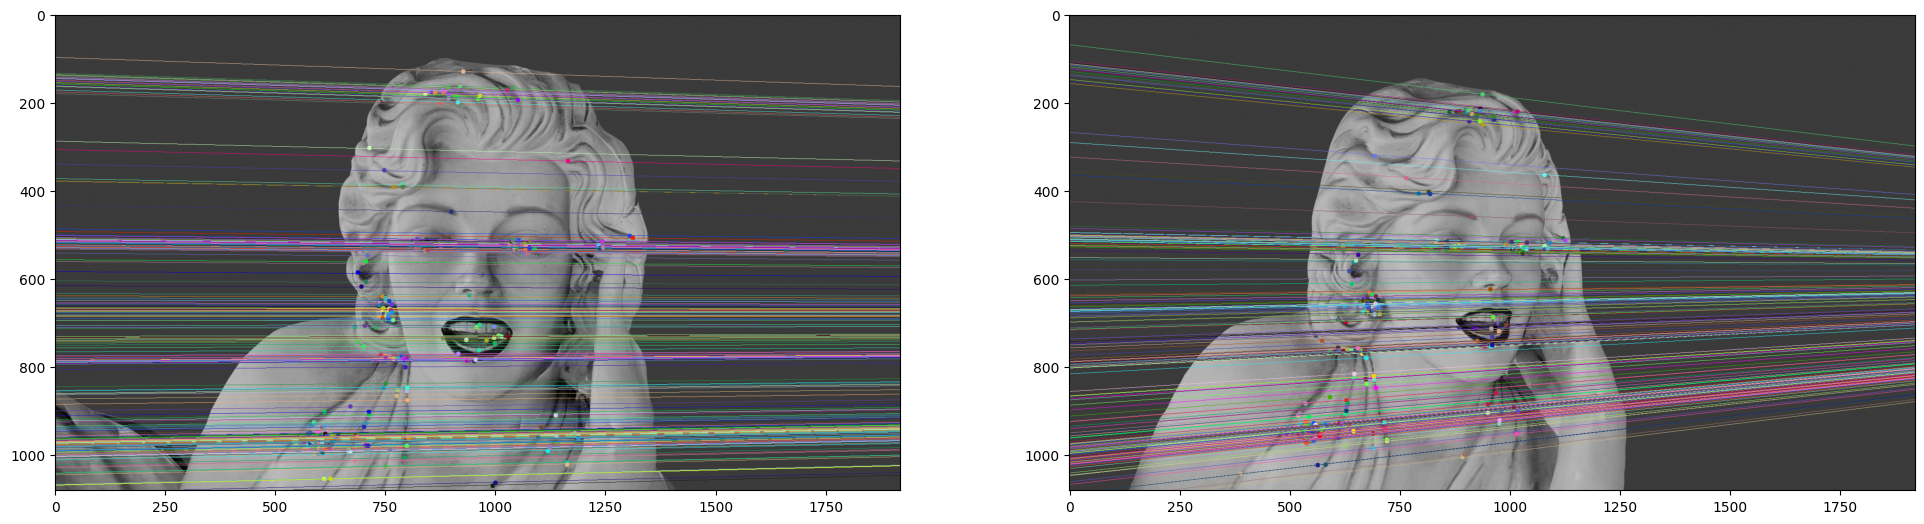

Number of point matches: 294


In [4]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.figure(figsize=(24, 12))
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()


print(f"Number of point matches: {len(pts1)}")

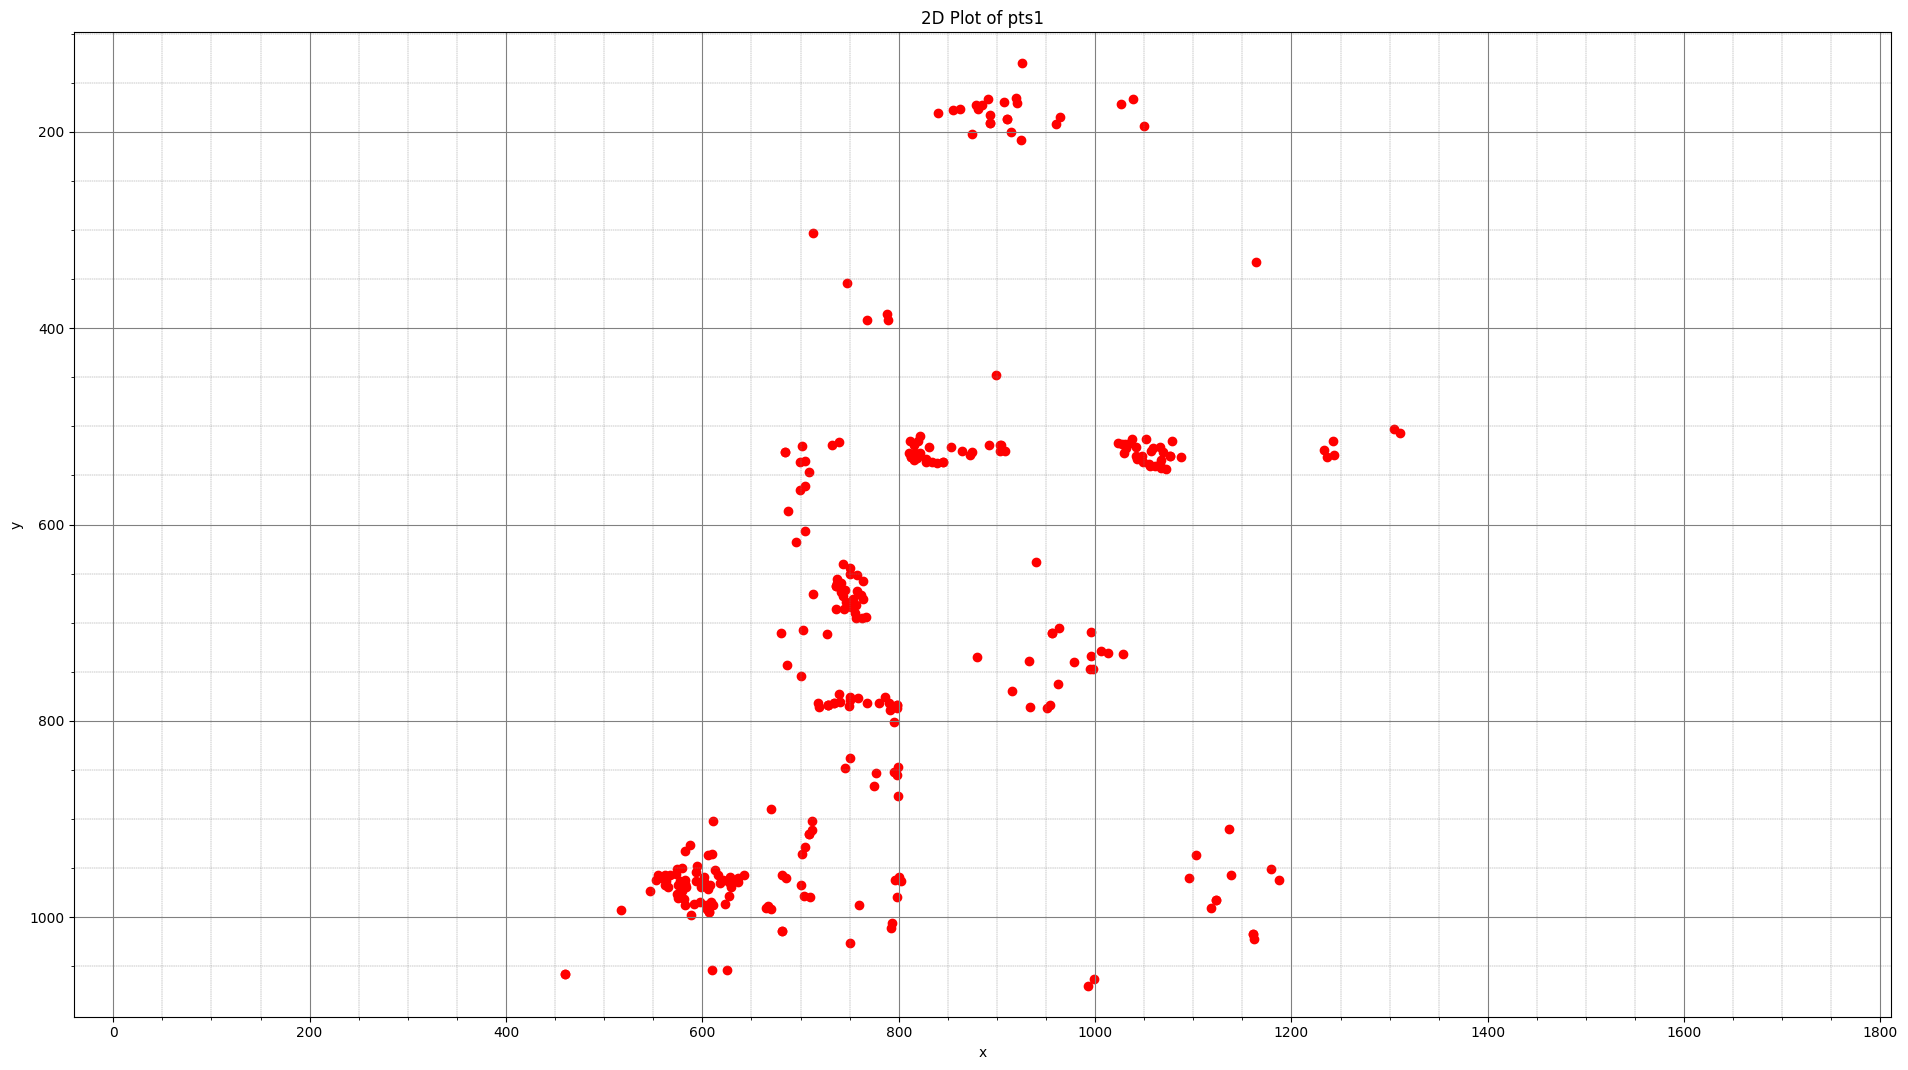

In [5]:
import matplotlib.pyplot as plt

dpi = 100
width_in = 1920 / dpi
height_in = 1080 / dpi

# Define fixed axis limits
xlim = (0, 1920)
ylim = (0, 1080)

plt.figure(figsize=(width_in, height_in), dpi=dpi)
plt.scatter(pts1[:, 0], pts1[:, 1], c="r", marker="o")

plt.xlim(xlim)
plt.ylim(ylim[::-1])  # Invert y-axis

# Set major ticks every 200 units
plt.xticks(range(xlim[0], xlim[1] + 1, 200))
plt.yticks(range(ylim[0], ylim[1] + 1, 200))

# Set minor ticks every 50 units
plt.gca().set_xticks(range(xlim[0], xlim[1] + 1, 50), minor=True)
plt.gca().set_yticks(range(ylim[0], ylim[1] + 1, 50), minor=True)

# Draw grid for both major and minor ticks
plt.grid(which="major", color="gray", linestyle="-", linewidth=0.8)
plt.grid(which="minor", color="gray", linestyle="--", linewidth=0.3)

plt.title("2D Plot of pts1")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.tight_layout()
plt.show()

In [6]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.spatial.transform import Rotation as R

# # --- Camera intrinsics ---
# focal_length_mm = 50
# sensor_width_mm = 36
# image_width_px = 1920
# image_height_px = 1080

# # Focal length in pixels
# focal_length_px = focal_length_mm * (image_width_px / sensor_width_mm)
# cx = image_width_px / 2
# cy = image_height_px / 2

# K = np.array([[focal_length_px, 0, cx], [0, focal_length_px, cy], [0, 0, 1]])

# # --- Camera extrinsics ---
# # Camera 1: (0, -1, 0), 90 deg X
# cam1_pos = np.array([0, -1, 0])
# cam1_rot = R.from_euler("x", 90, degrees=True).as_matrix()

# # Camera 2: (-0.5, -1, 0), -30 deg Z after 90 deg X
# cam2_pos = np.array([-0.5, -1, 0])
# cam2_rot = R.from_euler("z", -30, degrees=True).as_matrix() @ cam1_rot

# # Relative rotation and translation from cam1 to cam2
# R_1to2 = cam2_rot @ cam1_rot.T
# T_1to2 = cam2_pos - cam1_pos

# # --- Projection matrices ---
# P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])
# P2 = K @ np.hstack([R_1to2, T_1to2.reshape(-1, 1)])


# # --- Triangulation function (Direct Linear Transform) ---
# def triangulate_point(P1, P2, pt1, pt2):
#     x1, y1 = pt1
#     x2, y2 = pt2
#     A = np.array(
#         [x1 * P1[2] - P1[0], y1 * P1[2] - P1[1], x2 * P2[2] - P2[0], y2 * P2[2] - P2[1]]
#     )
#     _, _, V = np.linalg.svd(A)
#     X = V[-1]
#     return X[:3] / X[3]


# # Triangulate all points
# pts_3d = np.array(
#     [triangulate_point(P1, P2, pts1[i], pts2[i]) for i in range(pts1.shape[0])]
# )

# depth = pts_3d[:, 2]  # Z in cam1's frame

# # # --- Plotting ---
# # plt.figure(figsize=(1920 / 100, 1080 / 100), dpi=100)
# # plt.scatter(pts1[:, 0], pts1[:, 1], c=depth, cmap="viridis", marker="o")
# # plt.colorbar(label="Depth (meters)")
# # plt.title("Depth Map from pts1")
# # plt.xlabel("x")
# # plt.ylabel("y")
# # plt.axis("equal")
# # plt.tight_layout()
# # plt.show()

# # # Print 3D points and depth
# # for i, (p3d, d) in enumerate(zip(pts_3d, depth)):
# #     print(f"Point {i}: 3D = {p3d}, Depth = {d:.2f} meters")

In [7]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Use Qt backend for interactive 3D rotation
# %matplotlib qt

# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')

# # Correct indexing: pts_3d is shape (N, 3) where N is number of points
# # Each point has [x,y,z] in the second dimension
# ax.scatter(pts_3d[:, 0], pts_3d[:, 1], pts_3d[:, 2],
#            c=pts_3d[:, 2],  # Color by depth
#            cmap='viridis',
#            marker='o')

# # Add a color bar to show depth scale
# cbar = fig.colorbar(ax.scatter(pts_3d[:, 0], pts_3d[:, 1], pts_3d[:, 2],
#                               c=pts_3d[:, 2], cmap='viridis'),
#                    ax=ax, shrink=0.7, label='Depth (meters)')

# # Set labels and title
# ax.set_xlabel("X Coordinate")
# ax.set_ylabel("Y Coordinate")
# ax.set_zlabel("Z Coordinate")
# ax.set_title("3D Points Reconstruction")

# # Optional: Set better viewing angle
# ax.view_init(elev=30, azim=45)

# # Optional: Add camera positions
# # Draw camera 1 position
# ax.scatter([0], [-1], [0], color='red', marker='^', s=100, label='Camera 1')
# # Draw camera 2 position
# ax.scatter([-0.5], [-1], [0], color='green', marker='^', s=100, label='Camera 2')

# ax.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# original

%matplotlib qt

# import numpy as np
# import cv2 as cv
# import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Camera intrinsics
focal_length_mm = 50
sensor_width_mm = 36
image_width_px = 1920
image_height_px = 1080

# Calculate focal length in pixels
focal_length_px = (focal_length_mm / sensor_width_mm) * image_width_px

# Camera intrinsics matrix
K = np.array(
    [
        [focal_length_px, 0, image_width_px / 2],
        [0, focal_length_px, image_height_px / 2],
        [0, 0, 1],
    ]
)

R1 = cv.Rodrigues(np.deg2rad([15, 0, 0]))[0]
t1 = np.array([[0], [0], [-1]])

R2 = cv.Rodrigues(np.deg2rad([-30, 0, 0]))[0]
t2 = np.array([[-0.5], [0], [-1]])

# Projection matrices
P1 = K @ np.hstack((R1, t1))  # Projection matrix for the first camera
P2 = K @ np.hstack((R2, t2))  # Projection matrix for the second camera

# Assuming pts1 and pts2 are your matched points
# Ensure pts1 and pts2 are numpy arrays
pts1 = np.array(pts1, dtype=np.float32)  # 2D points from image 1
pts2 = np.array(pts2, dtype=np.float32)  # 2D points from image 2

# Check for equal lengths
if pts1.shape[0] != pts2.shape[0]:
    raise ValueError("The number of points in pts1 and pts2 must be the same.")

# Convert to homogeneous coordinates
pts1_hom = cv.convertPointsToHomogeneous(pts1).reshape(-1, 3)  # shape (N, 3)
pts2_hom = cv.convertPointsToHomogeneous(pts2).reshape(-1, 3)  # shape (N, 3)

# Triangulation
points_4D = cv.triangulatePoints(
    P1, P2, pts1_hom[:, :2].T, pts2_hom[:, :2].T
)  # shape (4, N)

# Normalize to convert to 3D coordinates
points_3D = points_4D[:3] / points_4D[3]  # Normalize by the last row

plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")

# Scatter plot of the 3D points
ax.scatter(points_3D[0], points_3D[1], points_3D[2], c="b", marker="o", s=4)

ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("3D Points Reconstruction")

plt.show()

2025-04-21 14:51:17.280 python[13725:77037] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-21 14:51:17.280 python[13725:77037] +[IMKInputSession subclass]: chose IMKInputSession_Modern
